In [69]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import pandas as pd
from glob import glob
from scipy.optimize import curve_fit
from scipy.constants import Planck
from scipy.constants import speed_of_light

In [98]:
I_sat=4.1 #mW/cm^2, Saturation Intensity taken from F20.pdf page 82
lw=2*np.pi*6.07 #MHz, Natural Line Width of RB 85 (what about 87?) taken from F20.pdf page 82
Trans=0.96 #a.u., Transmission of the optical viewport taken from F20.pdf page 83
radius=25.4 #mm, radius of the collecting lense taken from F20.pdf page 83
distance=150 #mm, distance between MOT and Photodiode taken from F20.pdf page 83
G=4.75e6 #V/A, Gain of Photdiode amplifier at +70dB taken from F20.pdf page 83
Gf=G*0.05 #V/A, Error of G taken from F20.pdf page 83
QE=0.52 #A/W, Quantum Efficiency of the sensor taken from F20.pdf page 83
QEf=0.015 #A/W, Error of QE taken from F20.pdf page 83
S=1e6/(1e6+50) #a.u., Scale Factor cause by impedance difference taken from F20.pdf page 83
sp_85=384.230406373e12 #Hz, S->P transition for RB85 taken from F20.pdf page 19
sf3_85=1.264888e9 #Hz, deltaF in S for F=3 for RB85 taken from F20.pdf page 19
pf2_85=83.835e6 #Hz, deltaF in P for F=2 for RB85 taken from F20.pdf page 19
pf4_85=100.205e6 #Hz, deltaF in P for F=4 for RB85 taken from F20.pdf page 19
detuning=10 #Mhz, best detuning value from part II (TODO: can't find prove we use it?)
powerx=8 #mW, Laserpower in x direction
powery=8 #mW, Laserpower in y direction
powerz=18 #mW, Laserpower in z direction
omega=0.2 #cm, width of Laser Beam taken from F20.pdf page 83
approx=0.043 #V, taken from Part II
#array which contains the values of 'offtime'
off=([1,2,3,4,5,7,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,30,35,40,45,55,60])

In [99]:
#defining laserintensity
def I_r():
    return 2*(powerx+powery+powerz)/(np.pi*omega**2)

#defining solid angle theta for conversion
def theta():
    return radius**2/(4*distance**2)

#defining scatteringRate for conversion
def scatteringRate():
    I_0 = I_r()
    resultScatteringRate = 1e6*(lw/2)*(I_0/I_sat)/(1+I_0/I_sat+4*detuning**2/lw**2)
    return resultScatteringRate

#defining wavelength with detuning for conversion
def wavelength():
    return speed_of_light/(sp_85-sf3_85+(pf4_85-pf2_85)/2-detuning*1e6)
#KEEP IN MIND: value is taken from second explanation on page 68 from F20.pdf

#defining energy from a phton with wavelength(detuning) for conversion
def energy():
    return Planck*speed_of_light/wavelength()

#translating voltage into #atoms
def conversion(voltage):
    scat = scatteringRate()
    eng = energy()
    angle = theta()
    natoms = voltage/(QE*G*S*Trans*angle*scat*eng)
    return natoms
    
#reading out the csv and returning time and voltage as arrays
def grabPart3(offtime):
    #offtime is an int specifying the time the trap was turn off
    #creating path without knowledge of number of .csv
    path='Part III/Off_'+str(offtime)+'/F*CH1.csv'
    #looking for the number of the .csv in the corresponding folder
    file = glob(path)[0]
    #reading the .csv
    dg = np.genfromtxt(file, delimiter=',')
    #6 dim array with most of them being 'empty' caused by the way Oscilloscope writes the .csv
    #Example of the first 3 'lines', column 0 and 1 become NaN as well after 17 lines
#                   0                   1   2      3     4   5
#0        Record Length        2.500000e+03 NaN  0.000  3.04 NaN
#1      Sample Interval        1.000000e-03 NaN  0.001  3.02 NaN
#2        Trigger Point  0.000000000000e+00 NaN  0.002  3.02 NaN
    #splitting the csv columns in 6 arrays from which we only want time and voltage
    g0,g1,g2,g3,g4,g5 = np.hsplit(dg,6)
    #g3=time, g4=voltage
    return g3,g4

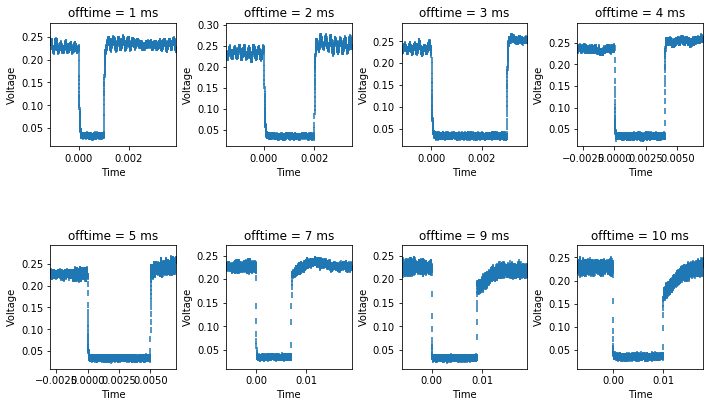

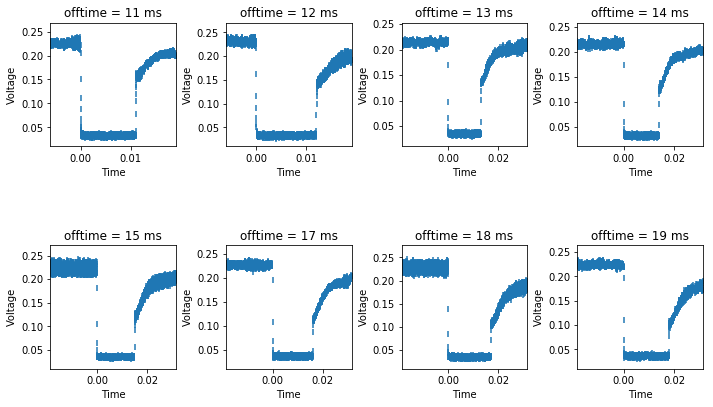

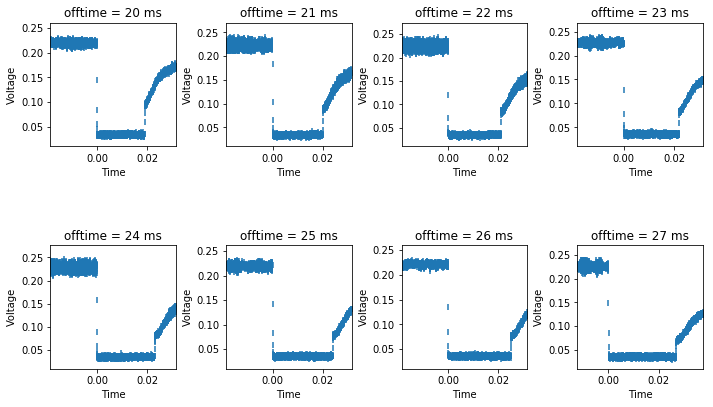

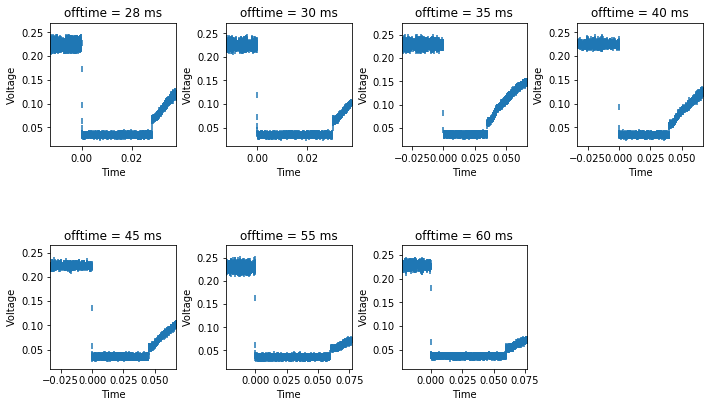

In [97]:
t_all = np.empty((np.size(off),2500,2))
u_all = np.empty((np.size(off),2500,2))

for i in enumerate(off):
    if i[0]==0: j=1
    delay = i[1]
    t,u = grabPart3(delay)
    #removing error signals?
    #t = t[np.where(u > 0.025)]
    #u = u[np.where(u > 0.025)]
    u_all[i[0],:]=u
    u_all[i[0],:,1]=i[0]
    t_all[i[0],:]=t
    t_all[i[0],:,1]=i[0]
    #drawing the subplots of just data while leaving "error" signals below 0.025V out 
    plt.subplot(2,4,j)
    plt.scatter(t,u,marker="|") 
    plt.xlim(t[0],t[-1])
    ymax=np.amax(u)+0.03
    plt.ylim(0.01,ymax)
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.title('offtime = '+str(delay)+' ms')
    #every 8 subplots = 1 picture
    j=j+1
    if(j>8): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
        j=1
    if(delay==60): 
        plt.subplots_adjust(wspace=0.4,hspace=0.8)
        plt.gcf().set_size_inches(11.69, 8.27/1.3)
        plt.show()
    #clean up    
    del t,u,delay

In [ ]:
n0_mean=np.empty((31,2))
n1_mean=np.empty((31,2))
for i in enumerate(off):
    #use turn off point is at t=0s
    t_off=-0.0005
    u_mod0=u_all[i[0],:,0][np.where(t_all[i[0],:,0] < t_off)]
    t_mod0=t_all[i[0],:,0][np.where(t_all[i[0],:,0] < t_off)]
    #use turn on point is at t=0s+i[1]/1000
    t_on=i[1]/1000+0.0005
    u_mod1=u_all[i[0],:,0][np.where(t_all[i[0],:,0] > t_on)]
    t_mod1=t_all[i[0],:,0][np.where(t_all[i[0],:,0] > t_on)]
    
    del u_mod0,t_mod0,u_mod1,t_mod1
    del t_on,t_off

In [100]:
0.00062/0.03402

0.018224573780129334